In [9]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch_geometric.utils as utils
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
from torch_geometric.nn import GCNConv, GAE

In [10]:
data_path = "../data/data.npz"
feat_dim = 10
num_classes = 64

num_epochs = 1000
learning_rate = 1e-3

In [11]:
data_dict = dict(np.load(data_path, allow_pickle=True).items())
A = data_dict["A"]
A = A[2, 9, ...]

A = torch.from_numpy(A)
X = torch.rand(A.shape[0], feat_dim)

edge_idx, edge_attr = utils.dense_to_sparse(A)
G = Data(x=X, edge_index=edge_idx, edge_attr=edge_attr)

assert not G.is_directed() and G.has_self_loops()

In [12]:
class Encoder(nn.Module):
    
    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.conv1 = GCNConv(in_channels, 2 * out_channels, add_self_loops=False)
        self.conv2 = GCNConv(2 * out_channels, out_channels, add_self_loops=False)

    def forward(self, X, edge_index):

        H = self.conv1(X, edge_index)
        Z = self.conv2(H, edge_index)

        return Z

In [13]:
encoder = Encoder(feat_dim, num_classes)
model = GAE(encoder=encoder)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epoch    0 | loss 1.9800
epoch  100 | loss 1.1900
epoch  200 | loss 1.0300
epoch  300 | loss 1.0100
epoch  400 | loss 1.0200
epoch  500 | loss 1.0200
epoch  600 | loss 0.9200
epoch  700 | loss 0.8600
epoch  800 | loss 0.9000
epoch  900 | loss 0.8600


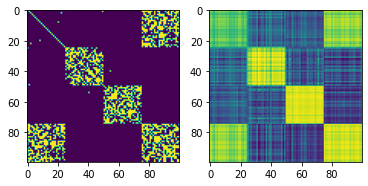

In [14]:
results = []

for epoch in range(num_epochs):
    
    model.train()
    optimizer.zero_grad()
    Z = model.encode(G.x, G.edge_index)
    loss = model.recon_loss(Z, G.edge_index)
    loss.backward()
    optimizer.step()
    results += [loss.item()]


    if epoch % 100 == 0:
        print("epoch {:4d} | loss {:06.4f}".format(epoch, round(results[-1], 2)))

model.eval()
with torch.no_grad():
    Z = model.encode(G.x, G.edge_index)
    A_recon = model.decoder.forward_all(Z)


fig, ax = plt.subplots(1, 2)
axes = ax.ravel()
axes[0].imshow(A.detach().numpy())
axes[1].imshow(A_recon.detach().sigmoid().numpy())
plt.show()